In [94]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [95]:
!pip install xgboost catboost lightgbm optuna

# Preparation


## Import libraries

In [96]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#Machine learning libraries
from sklearn.preprocessing import LabelEncoder,StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import optuna

## Import dataset

In [97]:
import pandas as pd
train = pd.read_csv("/Users/dangphamhai/untitled folder/train.csv", index_col="id")
test = pd.read_csv("/Users/dangphamhai/untitled folder/test.csv", index_col="id")

# Exploratory Data Analysis

In [98]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [99]:
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [100]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.6+ MB


### Check for Missing Values

In [101]:
train.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

### Summarize Statistics

In [102]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,39098.0,27.566781,6.032761,20.00,23.00,26.00,30.00,94.00
person_income,39098.0,64060.460842,37955.828705,4000.00,42000.00,58000.00,75885.00,1900000.00
person_emp_length,39098.0,4.687068,3.868395,0.00,2.00,4.00,7.00,42.00
loan_amnt,39098.0,9251.466188,5576.254680,700.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,39098.0,10.661216,3.020220,5.42,7.88,10.75,12.99,22.11
loan_percent_income,39098.0,0.159573,0.091633,0.00,0.09,0.14,0.21,0.73
cb_person_cred_hist_length,39098.0,5.830707,4.072157,2.00,3.00,4.00,8.00,30.00


Observations:
- Data has 58,645 entries and 12 columns. Of which 11 columns are predictors,  1 is the ID column, and column "loan_status" being the target of the model.
- Both datasets are well-structured and clean with no missing values.
- 4 columns are categorical predictors and 7 columns are numerical.

## Univariate Analysis  

### Distribution of loan status

<Axes: title={'center': 'Loan Status'}, xlabel='loan_status'>

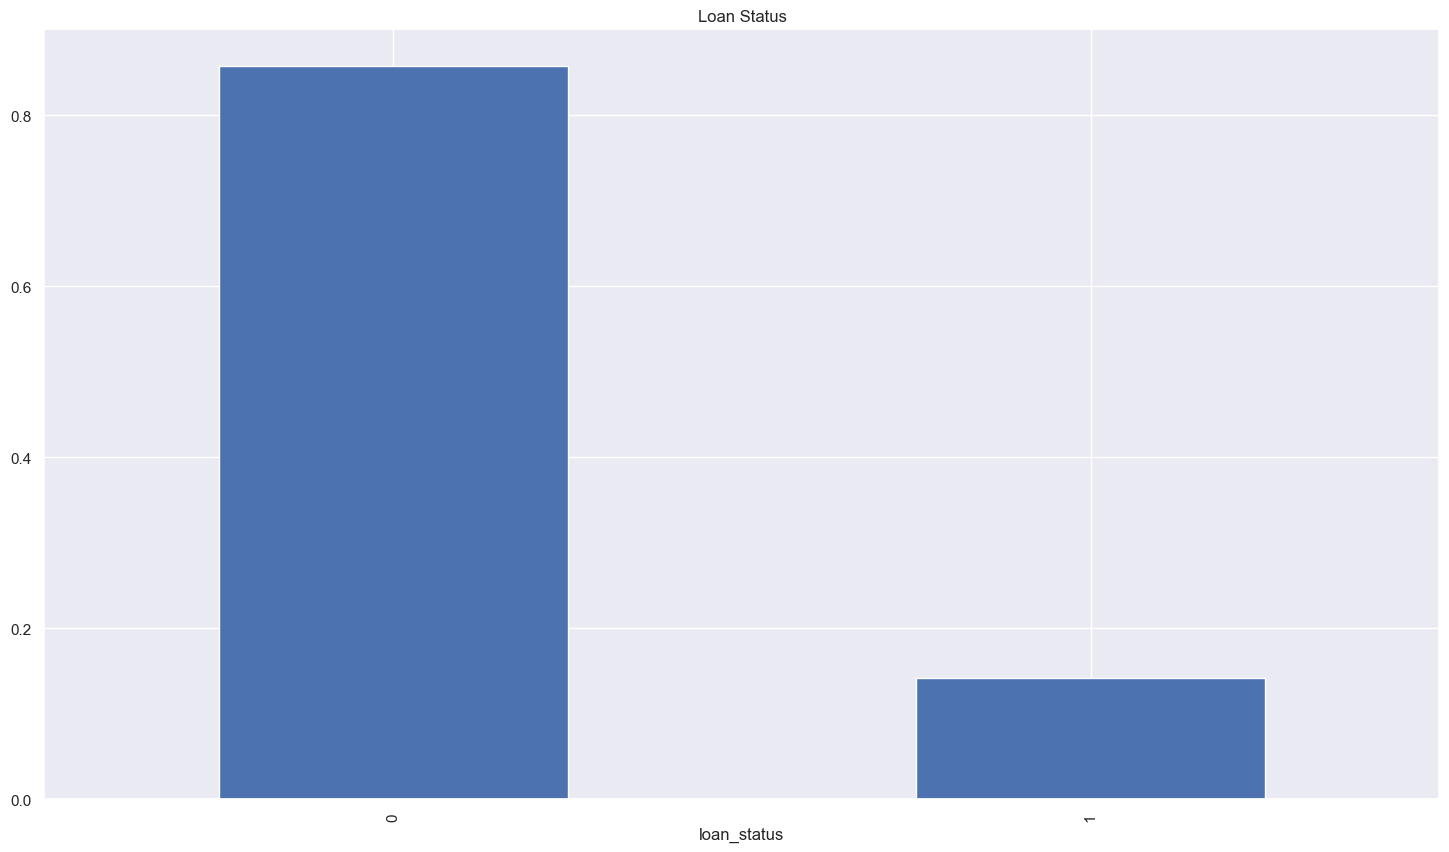

In [103]:
train.loan_status.value_counts(normalize=True).plot(kind='bar',title="Loan Status")

### Distribution of categorical features

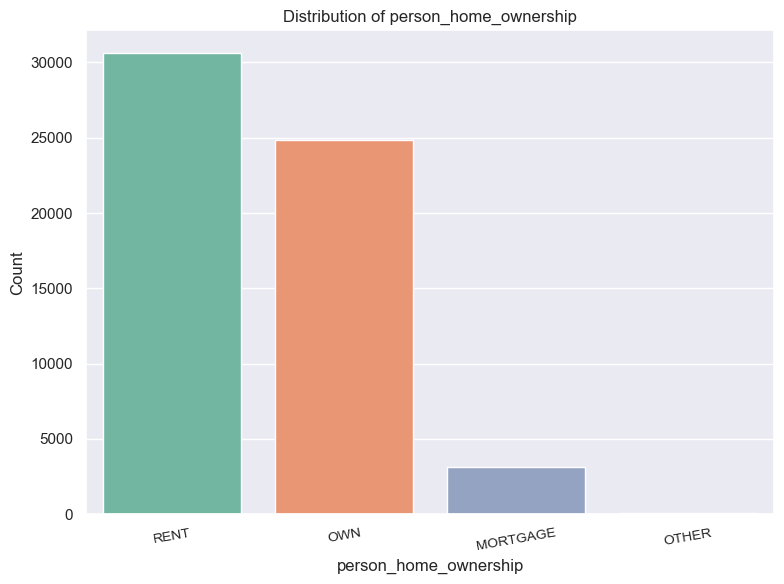

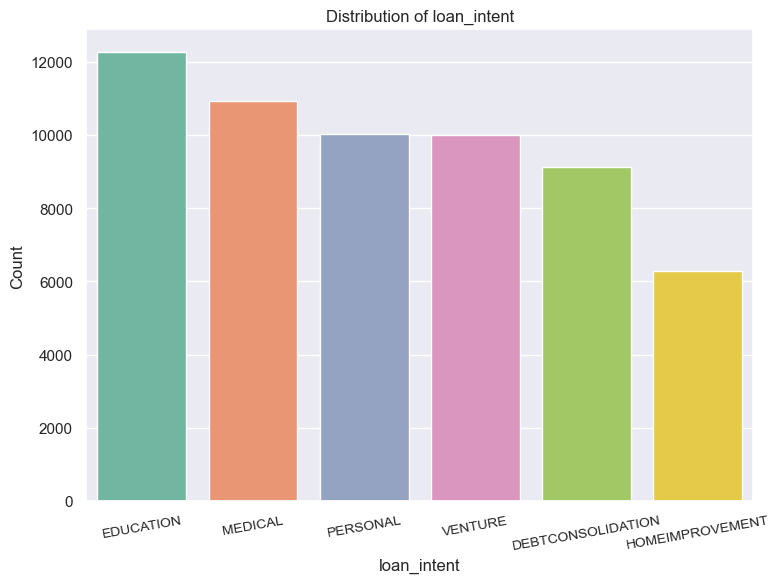

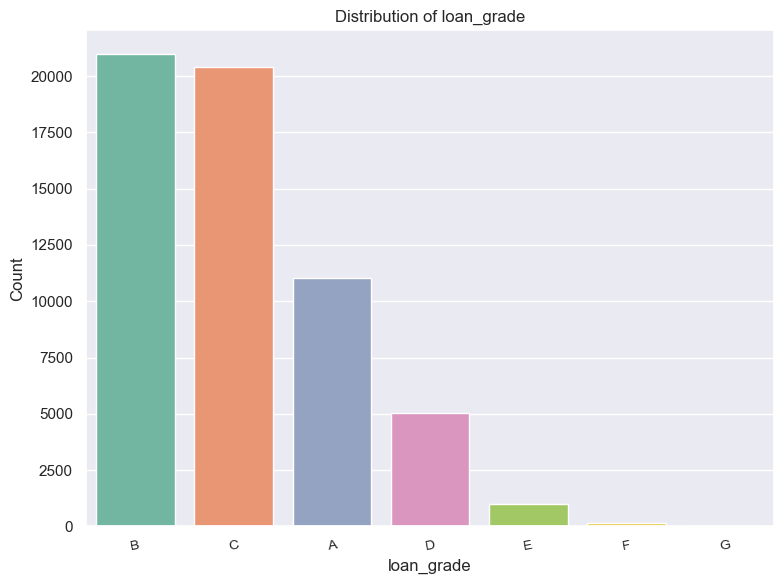

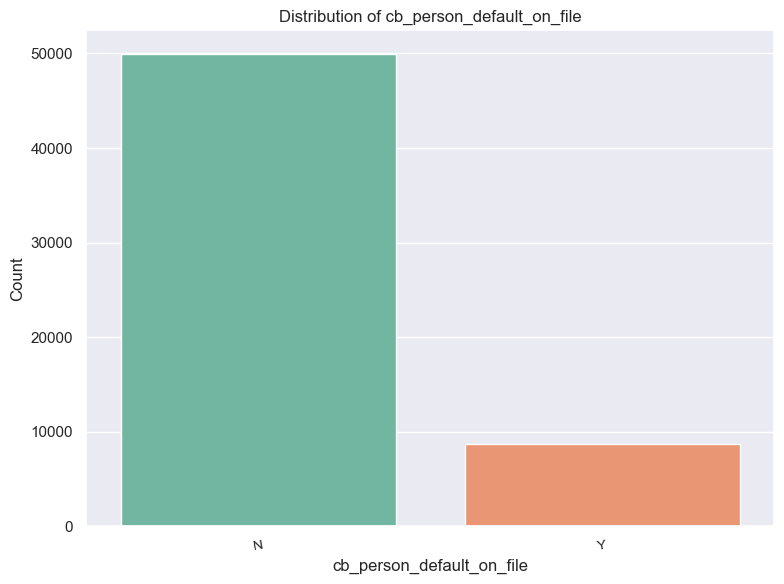

In [104]:
#Visualization for categorical variables
categorical_cols = ["person_home_ownership","loan_intent","loan_grade","cb_person_default_on_file"]

#Loop through the categorical columns and plot the count of each category
for column in categorical_cols:
    value_counts = train[column].value_counts().reset_index()
    value_counts.columns = [column,'Count']

    plt.figure(figsize=(8,6))
    sns.barplot(x = train[column].unique(), 
                y = train[column].value_counts(),
               palette='Set2')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=10, fontsize=10) 
    plt.tight_layout()

### Distribution of numerical features

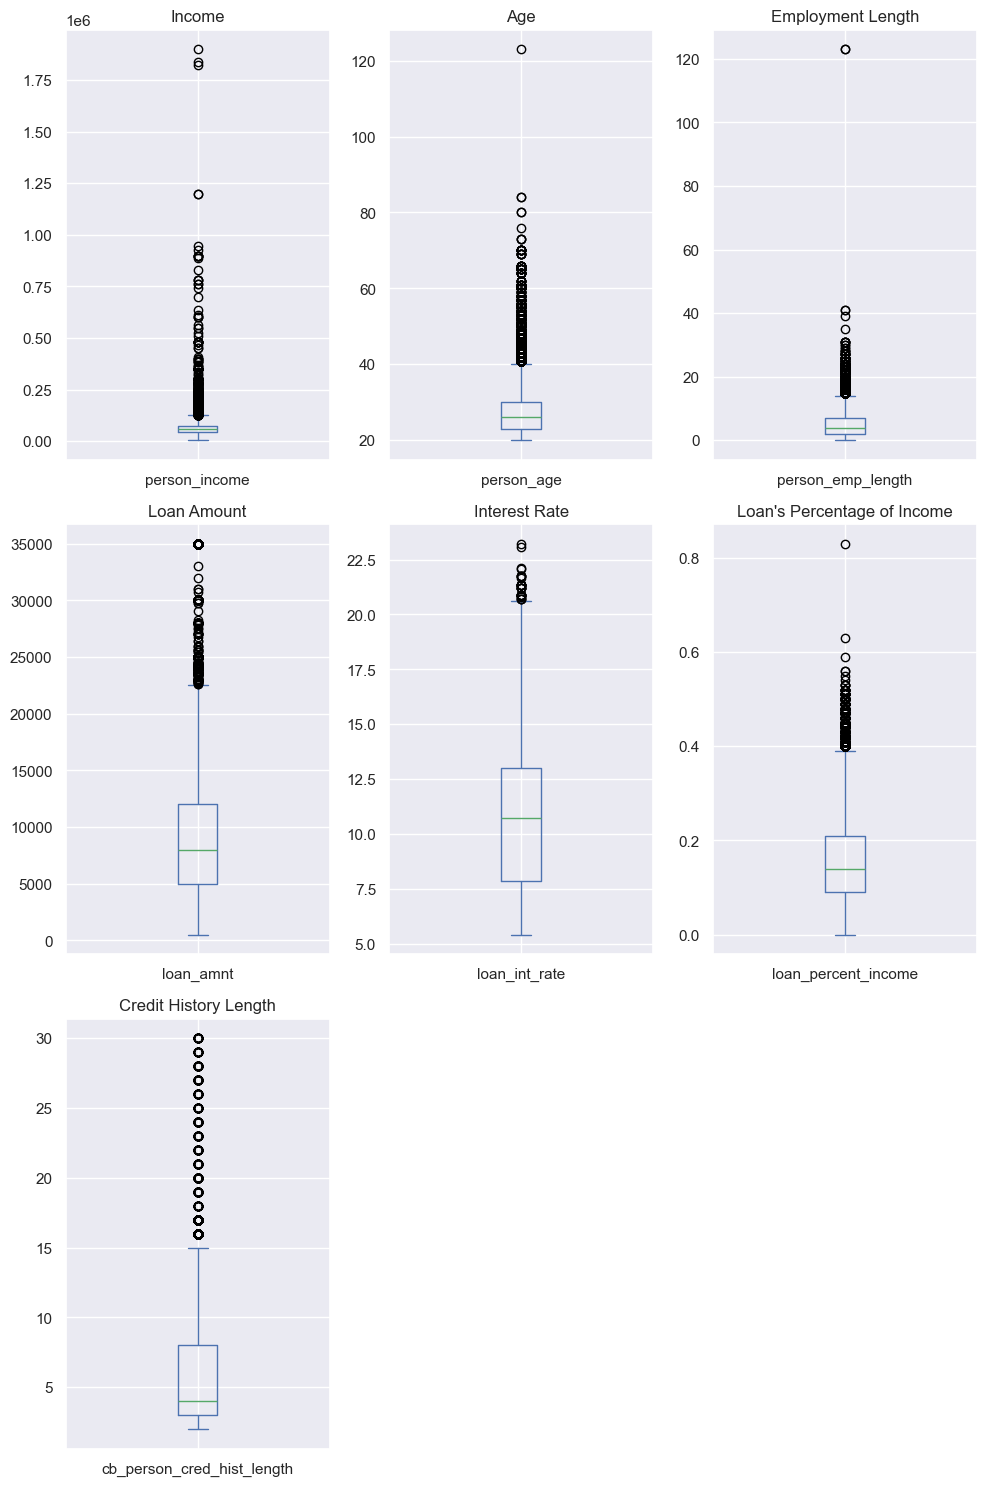

In [105]:
numerical_cols = [
    ("person_income", "Income"),
    ("person_age", "Age"),
    ("person_emp_length", "Employment Length"),
    ("loan_amnt", "Loan Amount"),
    ("loan_int_rate", "Interest Rate"),
    ("loan_percent_income", "Loan's Percentage of Income"),
    ("cb_person_cred_hist_length", "Credit History Length")
]

# Loop through the numerical columns and plot the distribution of each column
plt.figure(figsize=(50, 45))
for i, (col, title) in enumerate(numerical_cols, start=1):
    plt.subplot(3, 3, i) 
    train[col].plot.box(figsize=(10, 15))
    plt.title(title, fontsize=12)
    plt.tight_layout(pad=1)

plt.show()

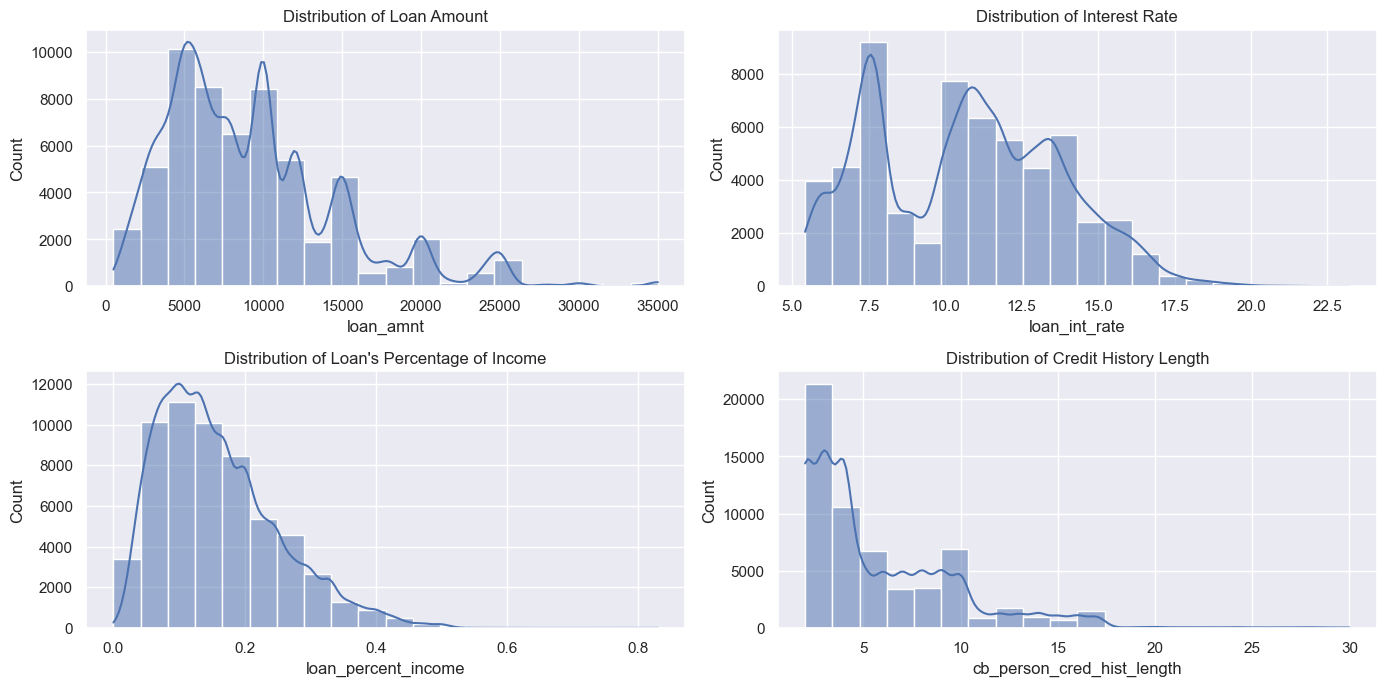

In [106]:
#Define numerical columns
numerical_cols_hist = [
    ("loan_amnt", "Loan Amount"),
    ("loan_int_rate", "Interest Rate"),
    ("loan_percent_income", "Loan's Percentage of Income"),
    ("cb_person_cred_hist_length", "Credit History Length")
]

#Loop though the numerical columns and plot the distribution of each column
plt.figure(figsize=(14,7))
for i, (column,title) in enumerate(numerical_cols_hist, start=1):
    plt.subplot(2,2,i)
    sns.histplot(train[column], 
                 bins=20, 
                 kde=True)
    plt.tight_layout(pad=1)
    plt.title(f'Distribution of {title}')

### Observations
- More than 80% of the loan is rejected
- More than 50% are rented houses and 40% are being financed by a mortgage
- Loan amount are concentrated between 2,000 and 20,000, with a couple of outliers
- Loan interest rate are mostly within 5-18% range, with a some outliers

## Bivariate Analysis

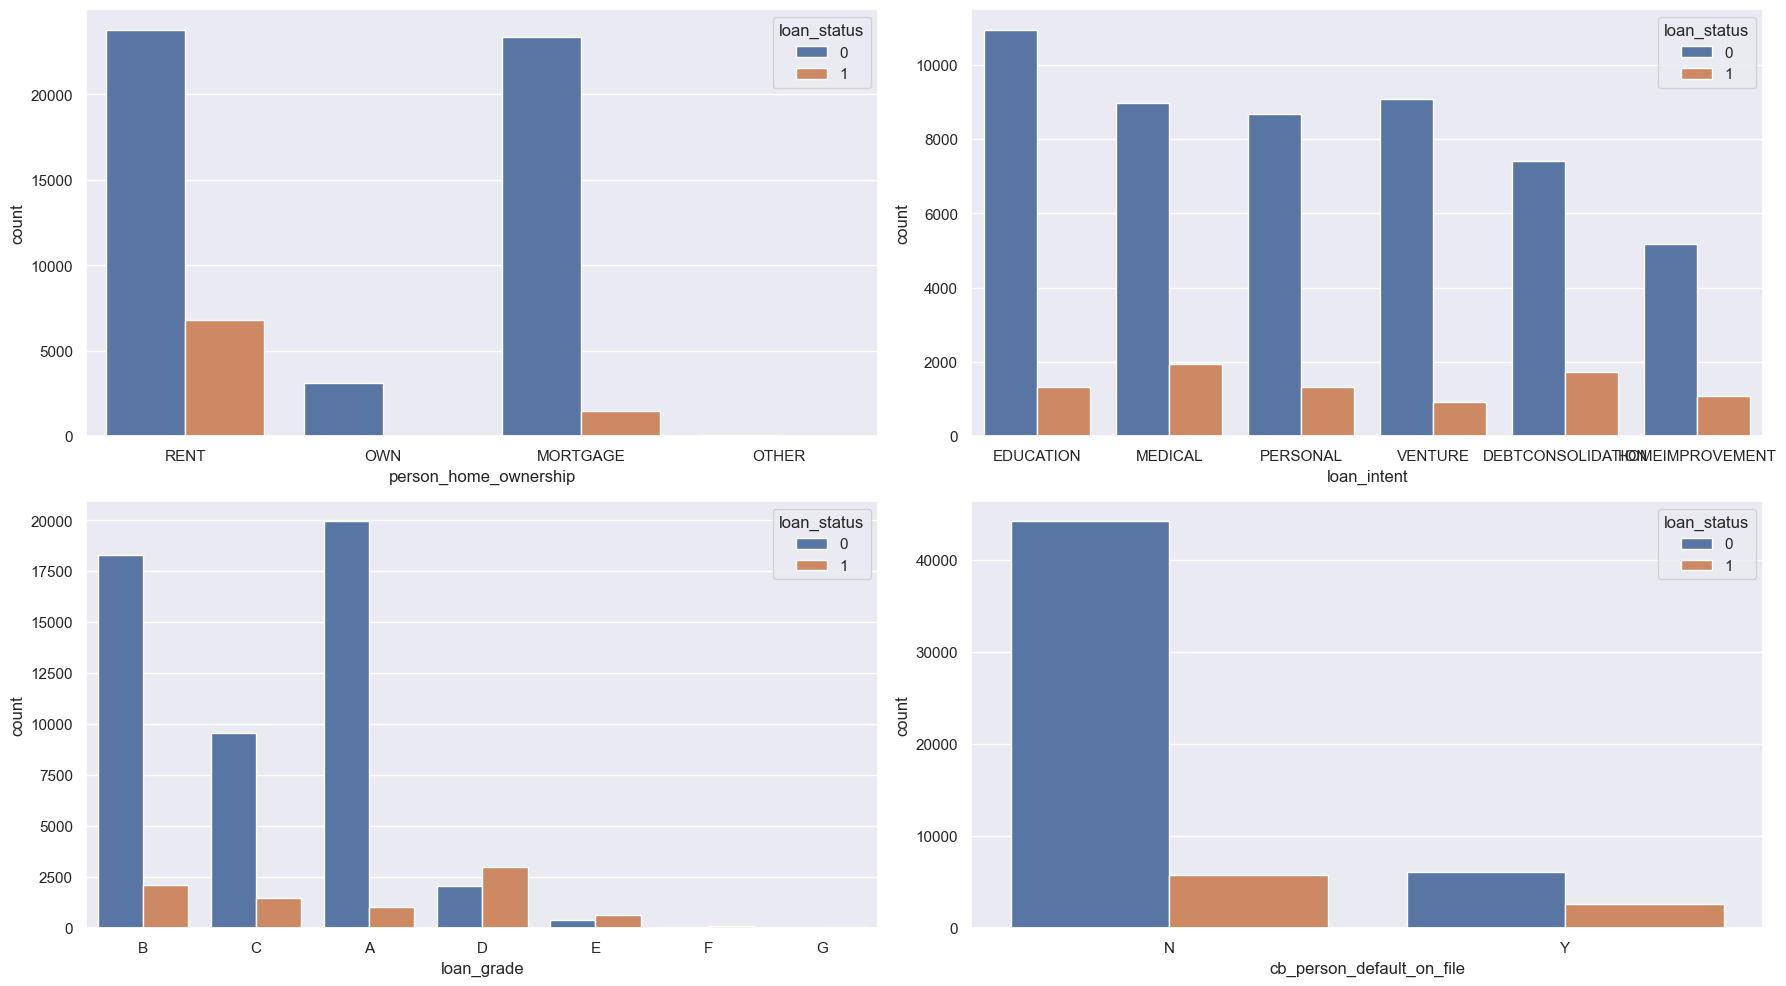

In [107]:
sns.set(rc={"figure.figsize":(18,10)})

#Plot home ownership and loan status
plt.subplot(221)
sns.countplot(x="person_home_ownership", hue="loan_status", data=train)
plt.tight_layout(pad=1)

#Plot loan intent and loan status
plt.subplot(222)
sns.countplot(x="loan_intent", hue="loan_status", data=train)
plt.tight_layout(pad=1)

#Plot loan grade and loan status
plt.subplot(223)
sns.countplot(x="loan_grade", hue="loan_status", data=train)
plt.tight_layout(pad=1)

#Plot default history and loan status
plt.subplot(224)
sns.countplot(x="cb_person_default_on_file", hue="loan_status", data=train)
plt.tight_layout(pad=1)

### Observation
- Applicants who rent home have higher chance of loan approval than ones who have a mortgage.
- Loans for medical, debt consolidation, home improvement have higher chance of approval than venture and education.
- There's a trend that the higher the grade of the loan, the less likely the loan is approved.
- The number of people who don't have default on file is significant larger than ones who have, therefore, it's difficult to see how that affect their loan status.

## Multivariate Analysis

In [108]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


<Axes: xlabel='loan_intent', ylabel='loan_amnt'>

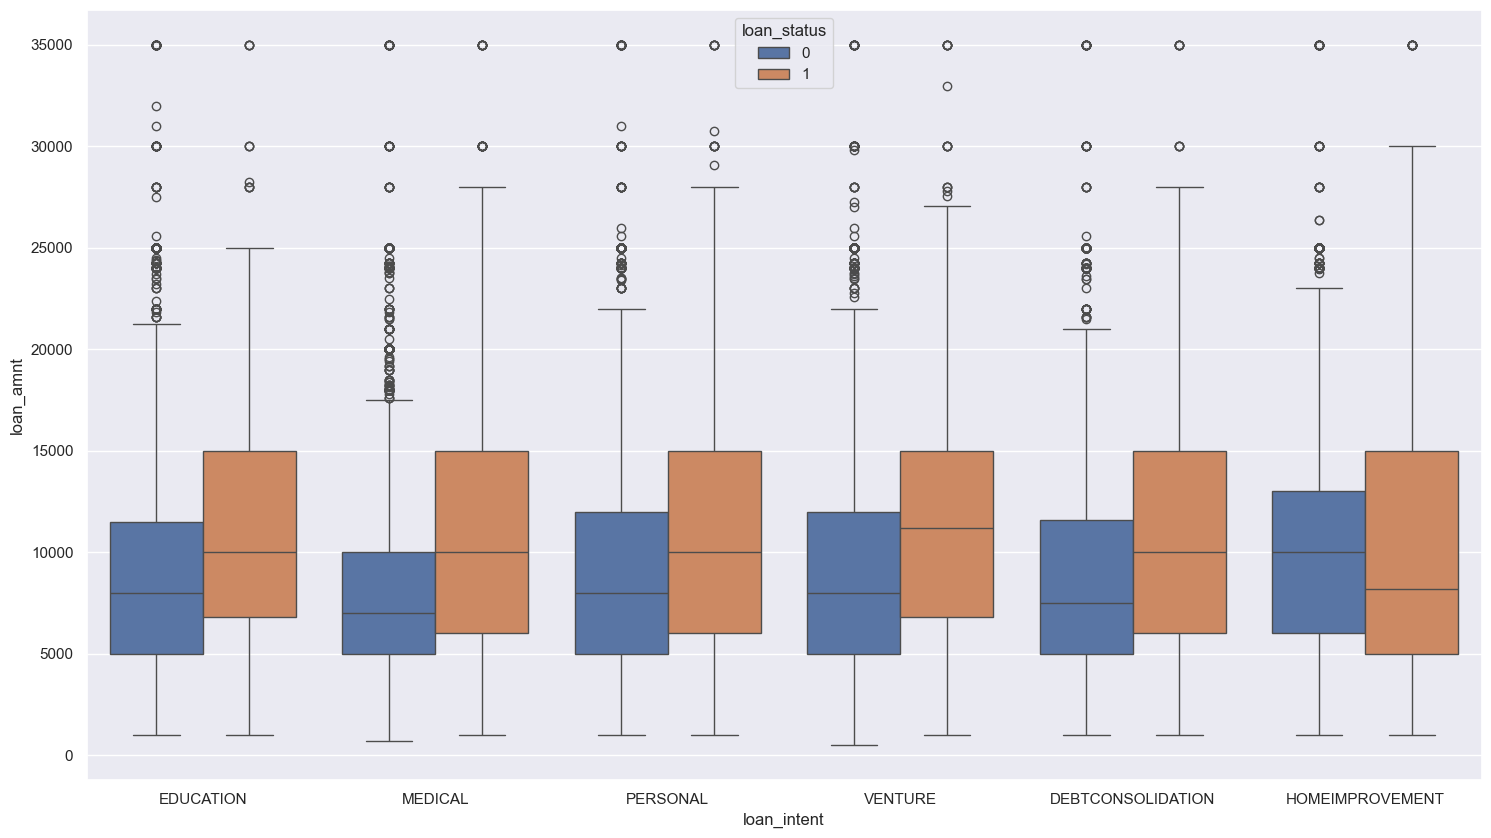

In [109]:
#Plot loan amount to loan intent, with loan status as hue
sns.boxplot(x='loan_intent', y='loan_amnt', data=train, hue='loan_status')


<Axes: xlabel='loan_grade', ylabel='loan_int_rate'>

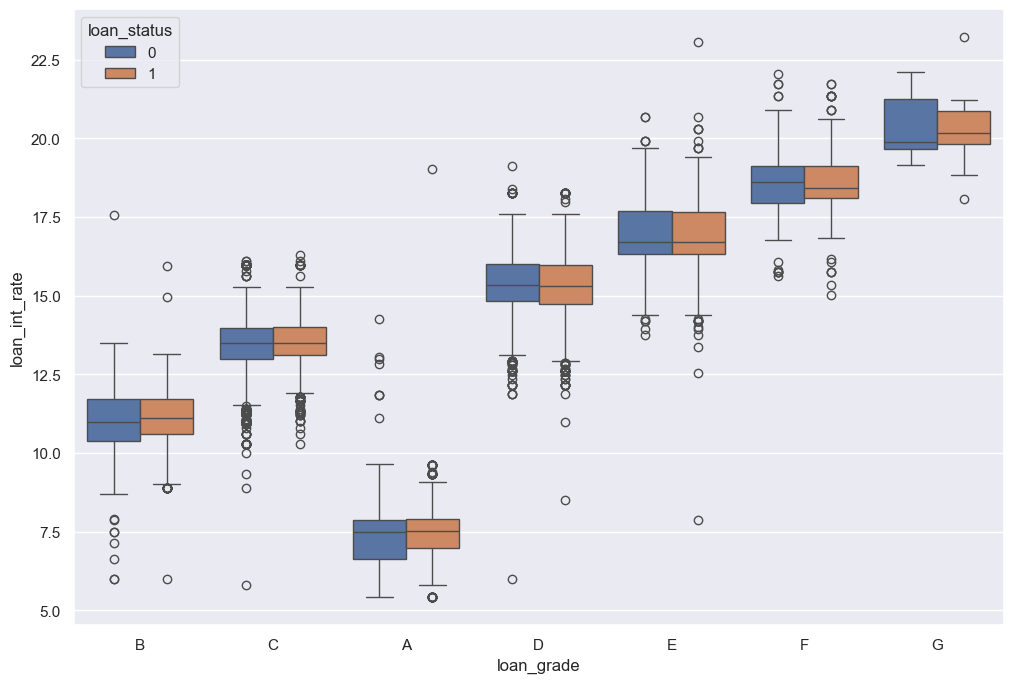

In [ ]:
#Plot loan interest rate to loan grade, with loan status as hue
plt.figure(figsize=(12, 8))
sns.boxplot(x='loan_grade', y='loan_int_rate', data=train, hue='loan_status')

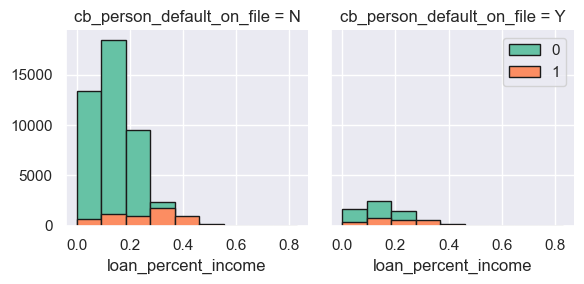

In [ ]:
import numpy as np

bins = np.linspace(train.loan_percent_income.min(),train.loan_percent_income.max(),10)
graph = sns.FacetGrid(train, col="cb_person_default_on_file", hue="loan_status", palette="Set2", col_wrap=2)
graph.map(plt.hist, "loan_percent_income", bins=bins, ec="k")
graph.axes[-1].legend()
plt.show()


### Correlation

In [19]:
#Create a correlation matrix
correlation_mat = train.corr(numeric_only=True)
correlation_mat

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
person_age,1.000000,0.102176,0.121276,0.050378,0.009653,-0.031975,0.874260,-0.001130
person_income,0.102176,1.000000,0.164042,0.310942,-0.057611,-0.280314,0.082727,-0.169956
person_emp_length,0.121276,0.164042,1.000000,0.092046,-0.101910,-0.065824,0.102842,-0.100428
loan_amnt,0.050378,0.310942,0.092046,1.000000,0.113582,0.647266,0.045720,0.144982
loan_int_rate,0.009653,-0.057611,-0.101910,0.113582,1.000000,0.152201,0.007535,0.338948
loan_percent_income,-0.031975,-0.280314,-0.065824,0.647266,0.152201,1.000000,-0.023202,0.378280
cb_person_cred_hist_length,0.874260,0.082727,0.102842,0.045720,0.007535,-0.023202,1.000000,-0.003030
loan_status,-0.001130,-0.169956,-0.100428,0.144982,0.338948,0.378280,-0.003030,1.000000


### Heat map

<Axes: >

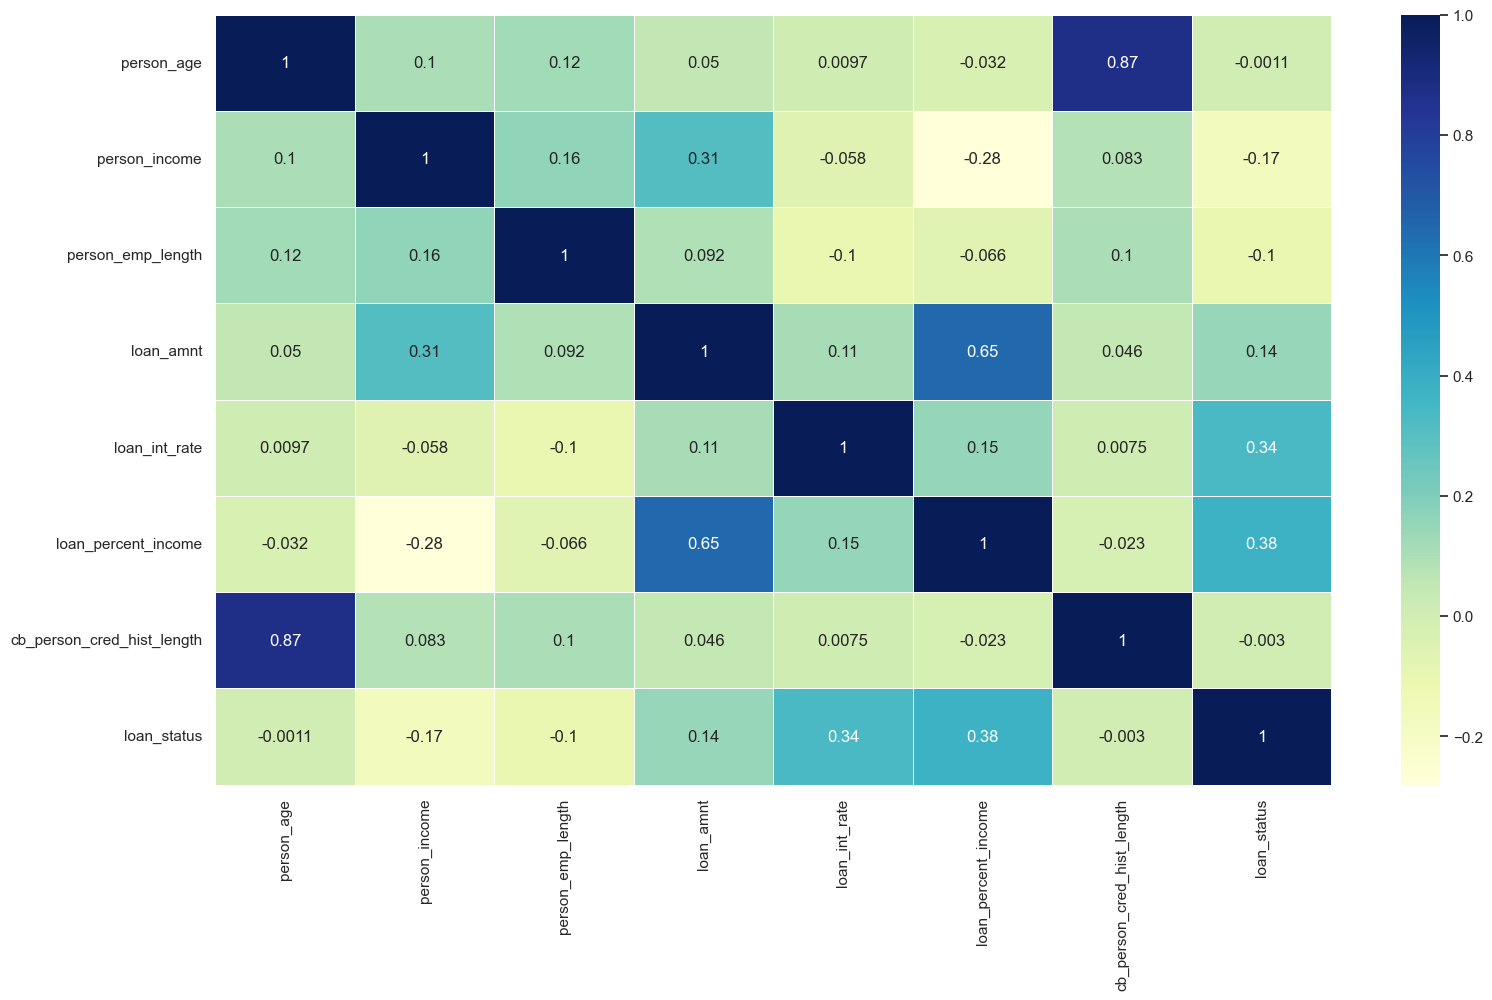

In [20]:
#Plot the heatmap of the correlation matrix
sns.heatmap(correlation_mat,annot=True,linewidths=0.5,cmap="YlGnBu")

### Observations
- There is a positive correlation between person_age and cb_person_cred_history_length, loan_percent_income and loan_amnt.
- There is moderate correlation between person_income and loan_amnt, loan_int_rate and loan_status, loan_percent_income and loan_status.

# Split Train and Validation Data

In [22]:
from sklearn.model_selection import train_test_split

#Separate X and y for train and test data
X = train.drop(["loan_status"], axis=1)
y = train.loan_status

#Divide train data into validate data
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2, random_state=0)



# Data Preprocessing

In [23]:
!pip install imbalanced-learn
import imblearn

In [24]:
#import imblearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

#Define categorical and numerical columns
numerical_cols = ["person_income",'person_age','person_emp_length','loan_amnt','loan_int_rate','loan_percent_income','cb_person_cred_hist_length']
categorical_cols = ["person_home_ownership","loan_intent","loan_grade","cb_person_default_on_file"]

#Preprocessing for numerical data
numerical_preprocessor = SimpleImputer(strategy="constant")

#Preprocessing for categorical data
categorical_preprocessor = Pipeline(steps=[
    ('impute',SimpleImputer(strategy="most_frequent")),
    ('onehot',OneHotEncoder(handle_unknown="ignore"))])

#Create a preprocessor for numerical and categorical data
preprocessor = ColumnTransformer(transformers=[
    ('numerical_preprocessor',numerical_preprocessor,numerical_cols),
    ('categorical_preprocessor', categorical_preprocessor, categorical_cols) 
])

#Preprocess numerical and categorical data
X_train_processed = preprocessor.fit_transform(X_train)
X_valid_processed = preprocessor.transform(X_valid)
test_processed    = preprocessor.transform(test)


In [86]:
#Get column names
numerical_cols = ["person_income",'person_age','person_emp_length','loan_amnt','loan_int_rate','loan_percent_income','cb_person_cred_hist_length']
categorical_cols = preprocessor.named_transformers_['categorical_preprocessor'].named_steps['onehot'].get_feature_names_out()
all_cols = list(numerical_cols) + list(categorical_cols)

#Put preprocessed data into DataFrame format
X_train_processed = pd.DataFrame(X_train_processed, columns = all_cols)
X_valid_processed = pd.DataFrame(X_valid_processed, columns = all_cols)
test_processed    = pd.DataFrame(test_processed, columns = all_cols)

In [87]:
test_processed

,person_income,person_age,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,x0_MORTGAGE,x0_OTHER,x0_OWN,...,x1_VENTURE,x2_A,x2_B,x2_C,x2_D,x2_E,x2_F,x2_G,x3_N,x3_Y
0,69000.0,23.0,3.0,25000.0,15.76,0.36,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,96000.0,26.0,6.0,10000.0,12.68,0.10,4.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,30000.0,26.0,5.0,4000.0,17.19,0.13,2.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,50000.0,33.0,4.0,7000.0,8.90,0.14,7.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,102000.0,26.0,8.0,15000.0,16.32,0.15,4.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39093,31200.0,22.0,2.0,3000.0,10.37,0.10,4.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39094,48000.0,22.0,6.0,7000.0,6.03,0.15,3.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39095,60000.0,51.0,0.0,15000.0,7.51,0.25,25.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39096,36000.0,22.0,4.0,14000.0,15.62,0.39,4.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# Feature Engineering

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [29]:
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [30]:
X_train_processed.head()

,person_income,person_age,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,x0_MORTGAGE,x0_OTHER,x0_OWN,...,x1_VENTURE,x2_A,x2_B,x2_C,x2_D,x2_E,x2_F,x2_G,x3_N,x3_Y
0,19000.0,21.0,2.0,3500.0,14.74,0.18,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,60000.0,22.0,6.0,10000.0,7.88,0.17,3.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,40000.0,21.0,5.0,1500.0,10.00,0.04,4.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,90000.0,33.0,4.0,14000.0,6.03,0.16,7.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,75000.0,27.0,7.0,3500.0,14.27,0.05,6.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [31]:
#Access MI score
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X,y)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_train_processed,y_train)
mi_scores

person_income                 0.095616
loan_int_rate                 0.084800
loan_percent_income           0.084366
x2_D                          0.054965
x0_RENT                       0.033990
x2_A                          0.024609
x0_MORTGAGE                   0.024356
x3_Y                          0.018216
x3_N                          0.017370
x2_E                          0.010701
loan_amnt                     0.010252
person_emp_length             0.008609
x0_OWN                        0.005316
x2_B                          0.004712
x2_G                          0.003473
person_age                    0.003054
x1_HOMEIMPROVEMENT            0.001614
x1_PERSONAL                   0.001026
x1_EDUCATION                  0.000798
x1_MEDICAL                    0.000056
cb_person_cred_hist_length    0.000035
x1_VENTURE                    0.000000
x2_C                          0.000000
x2_F                          0.000000
x1_DEBTCONSOLIDATION          0.000000
x0_OTHER                 

In [32]:
X_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46916 entries, 0 to 46915
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_income               46916 non-null  float64
 1   person_age                  46916 non-null  float64
 2   person_emp_length           46916 non-null  float64
 3   loan_amnt                   46916 non-null  float64
 4   loan_int_rate               46916 non-null  float64
 5   loan_percent_income         46916 non-null  float64
 6   cb_person_cred_hist_length  46916 non-null  float64
 7   x0_MORTGAGE                 46916 non-null  float64
 8   x0_OTHER                    46916 non-null  float64
 9   x0_OWN                      46916 non-null  float64
 10  x0_RENT                     46916 non-null  float64
 11  x1_DEBTCONSOLIDATION        46916 non-null  float64
 12  x1_EDUCATION                46916 non-null  float64
 13  x1_HOMEIMPROVEMENT          469

In [88]:
#Define functions to create new features
def create_features(df):
    # 1. Interest Amount Feature
    df['interest_amount'] = df['loan_amnt'] * df['loan_int_rate'] / 100

    # 3. Credit History to Age Ratio Feature
    df['cred_age_ratio'] = df['cb_person_cred_hist_length'] / df['person_age']

    # 7. Loan Amount to Income Ratio Feature
    df['loan_amnt_to_income_ratio'] = df['loan_amnt'] / df['person_income']

    # 8. Interest to Income Ratio Feature
    df['interest_to_income_ratio'] = df['loan_amnt'] * (df['loan_int_rate'] / 100) / df['person_income']

    return df

#Add features for test data
X_train_processed=create_features(X_train_processed)
X_valid_processed=create_features(X_valid_processed)
test_processed=create_features(test_processed)

# Machine Learning

In [34]:
X_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46916 entries, 0 to 46915
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_income               46916 non-null  float64
 1   person_age                  46916 non-null  float64
 2   person_emp_length           46916 non-null  float64
 3   loan_amnt                   46916 non-null  float64
 4   loan_int_rate               46916 non-null  float64
 5   loan_percent_income         46916 non-null  float64
 6   cb_person_cred_hist_length  46916 non-null  float64
 7   x0_MORTGAGE                 46916 non-null  float64
 8   x0_OTHER                    46916 non-null  float64
 9   x0_OWN                      46916 non-null  float64
 10  x0_RENT                     46916 non-null  float64
 11  x1_DEBTCONSOLIDATION        46916 non-null  float64
 12  x1_EDUCATION                46916 non-null  float64
 13  x1_HOMEIMPROVEMENT          469

## Random Forest

For each model, I'm using optuna to find the best hyperparameters for each algorithm and train and fit it.


#Optimize Hyperparameters

#Create objective function
import optuna
def objective(trial):
    #Create parameters
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]) 
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    #Create Random Forest model
    from sklearn.ensemble import RandomForestClassifier
    model_params = RandomForestClassifier(n_estimators = n_estimators, 
                              max_depth=max_depth, 
                              min_samples_split=min_samples_split, 
                              min_samples_leaf=min_samples_leaf, 
                              max_features = max_features,
                              bootstrap = bootstrap,
                              class_weight = class_weight,
                              criterion = criterion,
                              random_state=0)

    #Fit and train
    model_params.fit(X_train_processed, y_train)
    y_pred = model_params.predict_proba(X_valid_processed)[:,1]

    #Calculate metric
    from sklearn.metrics import roc_auc_score
    roc_auc = roc_auc_score(y_valid, y_pred)
    return roc_auc
    
#Create study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective,n_trials=200)
print("Best hyperparameters:",study.best_params)
print('Best ROC AUC:', study.best_value)

Best hyperparameters: {'n_estimators': 297, 'max_depth': 19, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': None, 'criterion': 'entropy'}

In [110]:
hyperparameters = {'n_estimators': 297, 'max_depth': 19, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': None, 'criterion': 'entropy'}
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(**hyperparameters, random_state=0)

In [111]:

#Fit model
random_forest.fit(X_train_processed, y_train)

#Predict probabilities on validation data
randomforest_preds = random_forest.predict_proba(X_valid_processed)[:,1]

#Evaluate the model
from sklearn.metrics import roc_auc_score
roc_auc_randomforest = roc_auc_score(y_valid,randomforest_preds)
print("ROC AUC score:", roc_auc_randomforest)

ROC AUC score: 0.9427007623319557


## XGBoost

#Optimize Parameters
from xgboost import XGBClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

#Create objective function
import optuna
def objective(trial):
    #Create parameters
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.6, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree",0.5,1.0)
    gamma = trial.suggest_float("gamma",0,5)
    reg_alpha = trial.suggest_float("reg_alpha",1e-5,10,log=True)
    reg_lambda = trial.suggest_float("reg_lambda",1e-5,10,log=True)

    #Create XGBoost model
    model_params = XGBClassifier(n_estimators = n_estimators, 
                                max_depth=max_depth, 
                                learning_rate=learning_rate, 
                                subsample=subsample,
                                colsample_bytree=colsample_bytree,
                                gamma=gamma,
                                reg_alpha=reg_alpha,
                                reg_lambda=reg_lambda,
                                random_state=0)

    #Fit and train
    model_params.fit(X_train_processed, y_train)
    y_pred = model_params.predict_proba(X_valid_processed)[:,1]

    #Calculate metric (MSE)
    from sklearn.metrics import roc_auc_score
    roc_auc = roc_auc_score(y_valid, y_pred)
    return roc_auc
    
#Create study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective,n_trials=200)
print("Best hyperparameters:",study.best_params)
print('Best ROC AUC:', study.best_value)

Best hyperparameters: {'n_estimators': 477, 'max_depth': 4, 'learning_rate': 0.10433533288012936, 'subsample': 0.9711870630568923, 'colsample_bytree': 0.8225439503491057, 'gamma': 0.3810401187365783, 'reg_alpha': 1.4620961011950038, 'reg_lambda': 0.0008696295608842862}
Best ROC AUC: 0.9580722765998917


In [112]:
#Calculating scale_pos_weight to address class imbalance
counts = y_train.value_counts()
positive_count = counts[0]
negative_count = counts[1]
scale_pos_weight = positive_count/negative_count
scale_pos_weight

6.029667365897513

In [53]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score

#Define hyperparameters
hyperparameters = {'n_estimators': 477, 'max_depth': 4, 'learning_rate': 0.10433533288012936, 'subsample': 0.9711870630568923, 'colsample_bytree': 0.8225439503491057, 'gamma': 0.3810401187365783, 'reg_alpha': 1.4620961011950038, 'reg_lambda': 0.0008696295608842862}

#Train model
xgb = XGBClassifier(**hyperparameters, scale_pos_weight=scale_pos_weight, random_state=0)
xgb.fit(X_train_processed, y_train,
        eval_set=[(X_valid_processed,y_valid)],
        
        verbose=500)

#Get predictions
xgb_preds = xgb.predict_proba(X_valid_processed)[:,1]

#Evaluate the model
roc_auc_xgb = roc_auc_score(y_valid,xgb_preds)
print("ROC AUC score:", roc_auc_xgb)

[0]	validation_0-logloss:0.64115
[476]	validation_0-logloss:0.21054
ROC AUC score: 0.9565595304314342


## CatBoost

#Optimize Parameters
from catboost import CatBoostClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

#Create objective function
import optuna
def objective(trial):
    #Create parameters
    iterations = trial.suggest_int('iterations', 100, 1000)
    depth = trial.suggest_int('depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    border_count=trial.suggest_int('border_count',32,255)
    subsample = trial.suggest_float('subsample', 0.5, 1)
    random_strength = trial.suggest_float("random_strength",1e-9,10)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg",3,8,log=True)
    grow_policy = trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
    eval_metric = 'AUC',
    verbose = 0
    random_seed = 42

    #Create CatBoost model
    model_params = CatBoostClassifier(iterations = iterations, 
                                depth=depth, 
                                learning_rate=learning_rate, 
                                border_count=border_count,
                                subsample=subsample,
                                random_strength=random_strength,
                                l2_leaf_reg=l2_leaf_reg,
                                grow_policy=grow_policy,
                                eval_metric = 'AUC',
                                verbose = 0,
                                random_seed = 42)

    #Fit and train
    model_params.fit(X_train_processed, y_train)
    y_pred = model_params.predict_proba(X_valid_processed)[:,1]

    #Calculate metric 
    from sklearn.metrics import roc_auc_score
    roc_auc = roc_auc_score(y_valid, y_pred)
    return roc_auc
    
#Create study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective,n_trials=15)
print("Best hyperparameters:",study.best_params)
print('Best ROC AUC:', study.best_value)

Best hyperparameters: {'iterations': 522, 'depth': 7, 'learning_rate': 0.24845578694503898, 'border_count': 245, 'subsample': 0.5790968262097773, 'random_strength': 7.493327243959743, 'l2_leaf_reg': 6.298026738758765, 'grow_policy': 'Lossguide'}
Best ROC AUC: 0.9560637689458281

In [62]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score

#Define hyperparameters
hyperparameters = {'iterations': 522, 'depth': 7, 'learning_rate': 0.24845578694503898, 'border_count': 245, 'subsample': 0.5790968262097773, 'random_strength': 7.493327243959743, 'l2_leaf_reg': 6.298026738758765, 'grow_policy': 'Lossguide'}

#Train model
catboost = CatBoostClassifier(**hyperparameters,
                             scale_pos_weight=scale_pos_weight)
catboost.fit(X_train_processed, y_train, eval_set=[(X_valid_processed, y_valid)], early_stopping_rounds=100, verbose=500) 

#Get predictions
catboost_preds = catboost.predict_proba(X_valid_processed)[:,1]

#Evaluate the model
roc_auc_catboost = roc_auc_score(y_valid,catboost_preds)
print("ROC AUC score:", roc_auc_catboost)

0:	learn: 0.5651425	test: 0.5621832	best: 0.5621832 (0)	total: 9.72ms	remaining: 5.07s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2576082351
bestIteration = 98

Shrink model to first 99 iterations.
ROC AUC score: 0.9568396686107782


## LightGBM

#Optimize Parameters
from lightgbm import LGBMClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

#Create objective function
import optuna
def objective(trial):
    #Create parameters
    max_depth = trial.suggest_int('max_depth', 3, 10)
    num_leaves = trial.suggest_int('num_leaves', 20, 150)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    feature_fraction=trial.suggest_float('feature_fraction',0.5,1.0)
    bagging_fraction=trial.suggest_float('bagging_fraction',0.5,1.0)
    bagging_freq = trial.suggest_int('bagging_freq', 1, 10)
    reg_alpha = trial.suggest_float("reg_alpha",0,10)
    reg_lambda = trial.suggest_float("reg_lambda", 0.0, 10.0)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    eval_metric = 'AUC'
    verbose = -1
    random_state = 0
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
    objective='binary'

    #Create CatBoost model
    model_params = LGBMClassifier(max_depth = max_depth,
                                      num_leaves=num_leaves,
                                      learning_rate=learning_rate,
                                      feature_fraction=feature_fraction,
                                      bagging_freq=bagging_freq,
                                      reg_alpha=reg_alpha,
                                      reg_lambda=reg_lambda,
                                      n_estimators=n_estimators,
                                      eval_metric = 'AUC',
                                      verbose = -1,
                                      random_state = 0,
                                      boosting_type = boosting_type,
                                      objective='binary')

    #Fit and train
    model_params.fit(X_train_processed, y_train)
    y_pred = model_params.predict_proba(X_valid_processed)[:,1]

    #Calculate metric 
    from sklearn.metrics import roc_auc_score
    roc_auc = roc_auc_score(y_valid, y_pred)
    return roc_auc
    
#Create study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective,n_trials=200)
print("Best hyperparameters:",study.best_params)
print('Best ROC AUC:', study.best_value)

Best hyperparameters: {'max_depth': 4, 'num_leaves': 22, 'learning_rate': 0.11654131115369387, 'feature_fraction': 0.5122947392234505, 'bagging_fraction': 0.8632072565221633, 'bagging_freq': 6, 'reg_alpha': 0.9133481637495522, 'reg_lambda': 7.299584252466292, 'n_estimators': 670, 'boosting_type': 'gbdt'}
Best ROC AUC: 0.9604459135080494

In [63]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score

#Define hyperparameters
hyperparameters = {'max_depth': 4, 'num_leaves': 22, 'learning_rate': 0.11654131115369387, 'feature_fraction': 0.5122947392234505, 'bagging_fraction': 0.8632072565221633, 'bagging_freq': 6, 'reg_alpha': 0.9133481637495522, 'reg_lambda': 7.299584252466292, 'n_estimators': 670, 'boosting_type': 'gbdt'}

#Train model
lgb = LGBMClassifier(**hyperparameters,
                    scale_pos_weight=scale_pos_weight)

lgb.fit(X_train_processed, y_train, 
        eval_set=[(X_valid_processed, y_valid)], 
) 

#Get predictions
lgb_preds = lgb.predict_proba(X_valid_processed)[:,1]

#Evaluate the model
roc_auc_lgb = roc_auc_score(y_valid,lgb_preds)
print("ROC AUC score:", roc_auc_lgb)

ROC AUC score: 0.9584220338649074


# Ensemble

## Soft Voting

In [64]:
#Average probabilities
softvoting_preds = (randomforest_preds + xgb_preds + catboost_preds + lgb_preds)/4

#Calculate ROC AUC on validation data
roc_auc_softvoting = roc_auc_score(y_valid,softvoting_preds)
print("ROC AUC on Validation Data with Soft Voting:", roc_auc_softvoting)

ROC AUC on Validation Data with Soft Voting: 0.9591590584223425


## Weighted Average

In [75]:
#Define weights for the models
weights = [0.1,0.2,0.4,0.3]

#Combine predictions using weighted average
weighted_preds = (weights[0] * randomforest_preds +
                 weights[1] * xgb_preds +
                 weights[2] * catboost_preds +
                 weights[3] * xgb_preds)

#Calculate ROC AUC on validation data
roc_auc_weighted = roc_auc_score(y_valid, weighted_preds)
print("ROC AUC oon Validation Data with Weighted Average:", roc_auc_weighted)

ROC AUC oon Validation Data with Weighted Average: 0.9584979441893524


# Evaluate

In [66]:
# Create a dictionary to store ROC AUC scores for the ensemble methods
roc_auc_ensemble = {
    "Soft Voting":roc_auc_softvoting,
    "Weighted Average":roc_auc_weighted
}

# Print the ensemble method and its score
for method, roc in roc_auc_ensemble.items():
    print(f"{method}:{roc}")

Soft Voting:0.9591590584223425
Weighted Average:0.9579507844699939


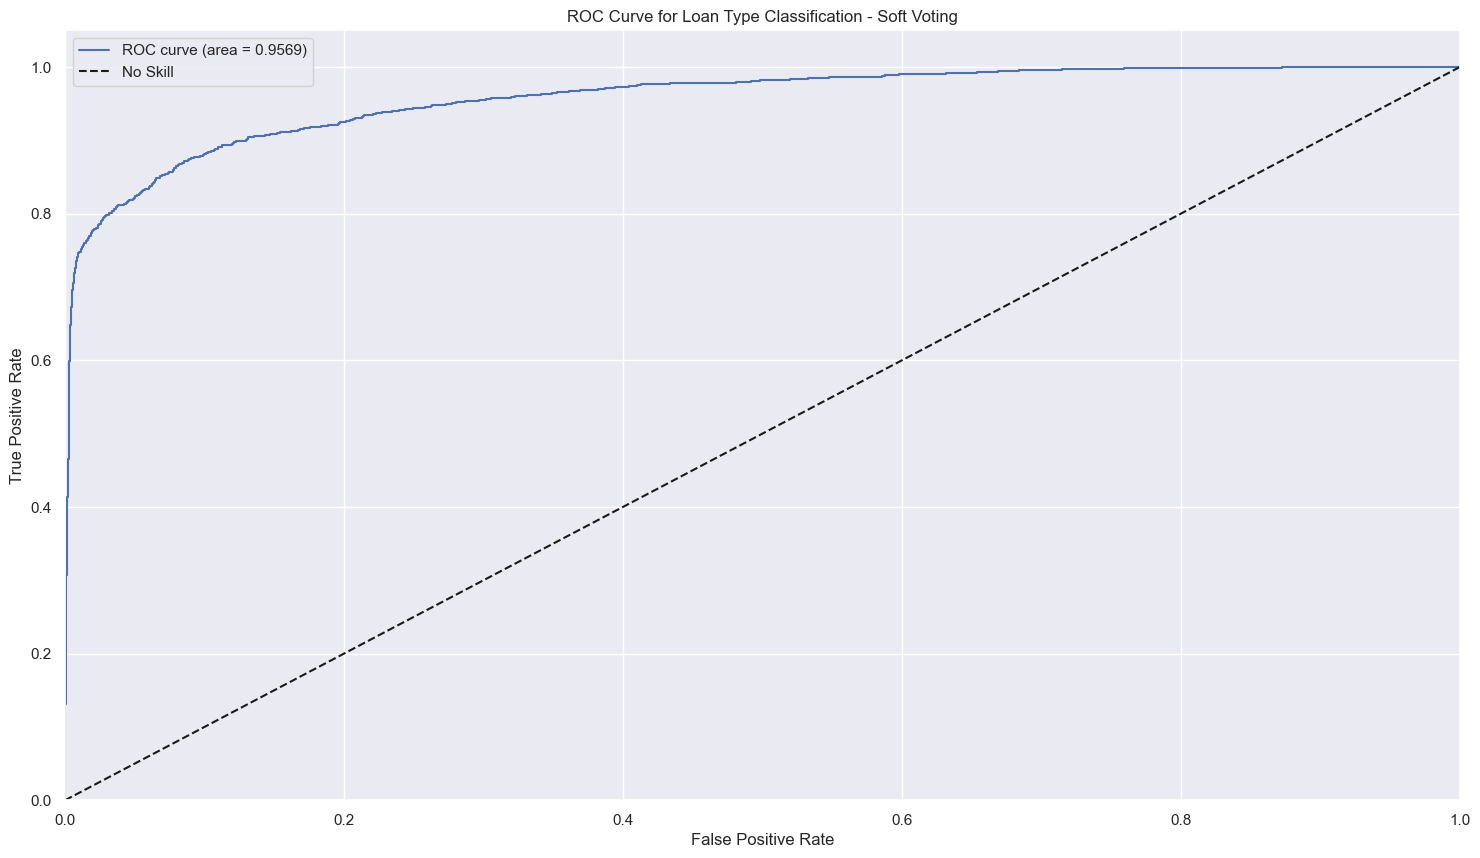

In [ ]:
from sklearn.metrics import roc_curve, auc
# Calculate ROC curve 
fpr, tpr, threshold = roc_curve(y_valid, softvoting_preds)
roc_auc = auc(fpr, tpr)

#Plot the ROC curve
plt.figure()

plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0,1], [0,1], 'k--', label="No Skill")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC Curve for Loan Type Classification - Soft Voting")
plt.legend()
plt.show()

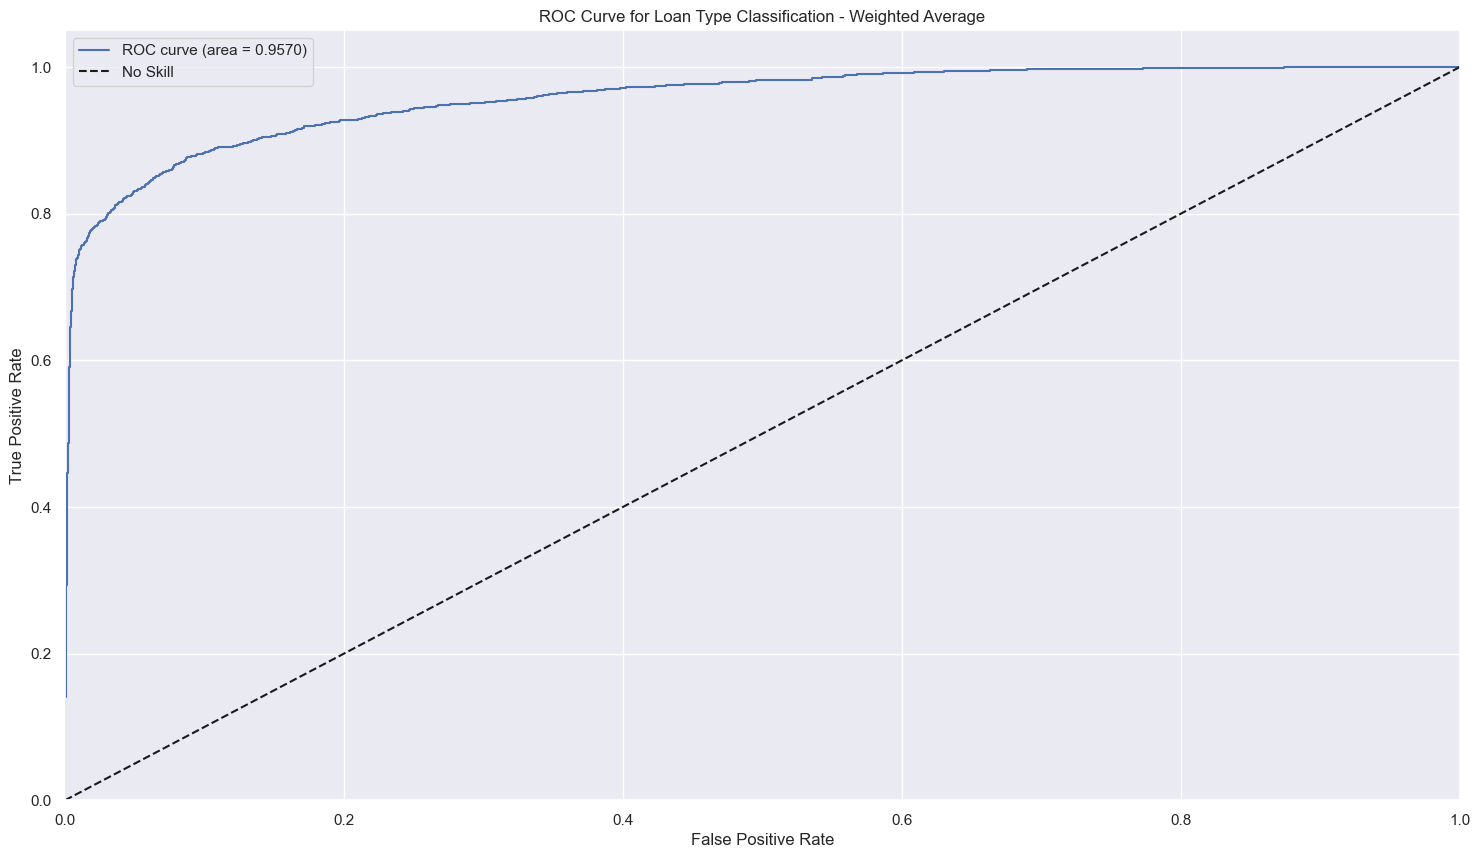

In [478]:
from sklearn.metrics import roc_curve, auc
# Calculate ROC curve 
fpr, tpr, threshold = roc_curve(y_valid, weighted_preds)
roc_auc = auc(fpr, tpr)

#Plot the ROC curve
plt.figure()

plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0,1], [0,1], 'k--', label="No Skill")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC Curve for Loan Type Classification - Weighted Average")
plt.legend()
plt.show()

# Submission

In [92]:
#Predict propbabilities on test data for both models 
randomforest_preds_test = random_forest.predict_proba(test_processed)[:,1]
xgb_preds_test = xgb.predict_proba(test_processed)[:,1]
catboost_preds_test = catboost.predict_proba(test_processed)[:,1]

#Combine predictions using soft voting
y_pred_test_ensemble = (randomforest_preds_test + xgb_preds_test + catboost_preds_test)/3

In [91]:
#Create submission file
df_sub = pd.read_csv('/Users/dangphamhai/untitled folder/sample_submission.csv')
df_sub["loan_status"] = y_pred_test_ensemble
df_sub.to_csv("submission.csv")
df_sub.head()

,id,loan_status
0,58645,0.697206
1,58646,0.048770
2,58647,0.581136
3,58648,0.025551
4,58649,0.128147
